In [2]:
#!pip list --format=freeze > requirements.txt

In [5]:
import yfinance as yf
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ta
from datetime import datetime

In [3]:
# Sector for financial fundamentals
sector_data = pd.read_csv('sector_averages.csv', index_col=0)
sector_data
cols = ['P/B', 'D/E', 'Y/Y Revenue Growth (S&P)', 'Gross Profit Margin']
sector_data[cols] = sector_data[cols].apply(pd.to_numeric, errors='coerce')
sector_data

,P/B,D/E,Y/Y Revenue Growth (S&P),Gross Profit Margin
Basic Materials,2.74,0.5902,4.0,7.09
Communication Services,5.10,0.7963,8.4,14.96
Consumer Cyclical,10.06,0.8996,4.1,6.10
Consumer Defensive,6.33,0.7755,3.3,4.91
Energy,1.99,0.5706,-1.8,6.88
Financial Services,2.33,2.4550,6.8,18.81
Healthcare,4.86,0.8420,8.0,4.67
Industrials,6.35,0.8789,4.5,7.26
Real Estate,3.02,1.0660,5.6,9.79
Tech,13.09,0.4845,14.2,17.45


In [4]:
# Create screener params
tech_query = yf.EquityQuery('and', [
    yf.EquityQuery('is-in', ['exchange', 'NYQ', 'NMS', 'ASE', 'NCM']),
    yf.EquityQuery('is-in', ['sector', 'Technology']),
    yf.EquityQuery('LT', ['pricebookratio.quarterly', sector_data.loc['Tech', 'P/B']]),
    yf.EquityQuery('LT', ['totaldebtequity.lasttwelvemonths', sector_data.loc['Tech', 'D/E']]),
    yf.EquityQuery('GTE', ['totalrevenues1yrgrowth.lasttwelvemonths', 4]),
    yf.EquityQuery('GTE', ['grossprofitmargin.lasttwelvemonths', sector_data.loc['Tech', 'Gross Profit Margin']]),
    yf.EquityQuery('GTE', ['altmanzscoreusingtheaveragestockinformationforaperiod.lasttwelvemonths', 2.8]),
                   ])

In [5]:
# Create a list of stock tickers from screened stocks
response = yf.screen(tech_query, sortField ='pricebookratio.quarterly', sortAsc=True, size=100)
print(f'Number of stocks retrieved: {response['total']}')
data = response['quotes']

tech_stocks = {stocks['displayName']: stocks['symbol'] for stocks in data}
print(tech_stocks)

Number of stocks retrieved: 10
{'Wix.com': 'WIX', 'Fair Isaac': 'FICO', 'Next Technology Holding': 'NXTT', 'Electro-Sensors': 'ELSE', 'Tuya': 'TUYA', 'Yalla': 'YALA', 'Full Truck Alliance': 'YMM', 'Quantum Computing': 'QUBT', 'M-tron Industries': 'MPTI', 'GitLab': 'GTLB'}


# Ticker

In [6]:
wix = yf.Ticker('WIX')
def get_ticker(stock_symbol):
    stock = yf.Ticker(stock_symbol)
    return stock
ticker = get_ticker('FICO')

# Get Financial Statements and Useful Variables

In [7]:
def financial_statements(ticker):
    income_y = ticker.get_income_stmt()
    income_y = income_y.transpose()
    income_q = ticker.get_income_stmt(freq='quarterly')
    income_q = income_q.transpose()
    balance_y = ticker.get_balance_sheet()
    balance_y = balance_y.transpose()
    balance_q = ticker.get_balance_sheet(freq='quarterly')
    balance_q = balance_q.transpose()
    cashflow_y = ticker.get_cash_flow()
    cashflow_y = cashflow_y.transpose()
    cashflow_q = ticker.get_cash_flow(freq='quarterly')
    cashflow_q = cashflow_q.transpose()
    return income_y, income_q, balance_y, balance_q, cashflow_y, cashflow_q
income_y, income_q, balance_y, balance_q, cashflow_y, cashflow_q = financial_statements(ticker)

def useful_variables(year_data, quarter_data):
    years = year_data.index.tolist()
    years = [d.strftime('%Y-%m-%d') for d in years]
    quarters = quarter_data.index.to_period('Q').astype(str)
    return years, quarters
years, quarters = useful_variables(income_y, income_q)

## Analyst Price Targets

In [8]:
def get_price_targets(ticker):
    analyst = ticker.analyst_price_targets
    upside_potential = analyst['median'] / analyst['current']
    risk_adjusted = (analyst['low'] + analyst['high'] + analyst['mean']) / 3
    print(f'The lowest analyst estimate for {ticker.info['shortName']} is: ${analyst['low']}')
    print(f'The median analyst estimate for {ticker.info['shortName']} is: ${analyst['median']}')
    print(f'The highest analyst estimate for {ticker.info['shortName']} is: ${analyst['high']}')
    print(f'The upside potential for {ticker.info['shortName']} is: {round(upside_potential * 100, 2)}%')
    print(f'The risk-adjusted target for {ticker.info['shortName']} is ${round(risk_adjusted, 2)}')
get_price_targets(ticker)

The lowest analyst estimate for Fair Isaac Corporation is: $1230.0
The median analyst estimate for Fair Isaac Corporation is: $2050.0
The highest analyst estimate for Fair Isaac Corporation is: $2400.0
The upside potential for Fair Isaac Corporation is: 119.15%
The risk-adjusted target for Fair Isaac Corporation is $1882.15


## Insider and Institutional Stats

In [9]:
def get_insider_stats(ticker):
    holders = ticker.major_holders
    print(f'The percentage held by insiders: {round(holders.loc['insidersPercentHeld', 'Value'] * 100, 4)}%')
    print(f'The percentage held by institutions: {round(holders.loc['institutionsPercentHeld', 'Value'] * 100, 4)}%')
    print(ticker.insider_purchases)
get_insider_stats(ticker)

The percentage held by insiders: 2.589%
The percentage held by institutions: 91.277%
       Insider Purchases Last 6m    Shares  Trans
0                      Purchases   45914.0      9
1                          Sales   33453.0      9
2    Net Shares Purchased (Sold)   12461.0     18
3      Total Insider Shares Held  613827.0   <NA>
4  % Net Shares Purchased (Sold)     0.021   <NA>
5                   % Buy Shares     0.076   <NA>
6                  % Sell Shares     0.056   <NA>


## Yearly Net Income

In [10]:
def get_netincome_y(ticker, income, ticks):
    # Graphs yearly net income
    ni_year_bar = px.bar(income, x=income.index, 
                         y='NetIncome', title=f'{ticker.info['shortName']} Yearly Net Income', height=500)
    ni_year_bar.update_layout(xaxis_title='Date', yaxis_title='Net Income')
    ni_year_bar.update_xaxes(tickvals=income.index,
                             ticktext=years)
    ni_year_bar.show()
get_netincome_y(ticker=ticker,income=income_y,ticks=years)

## Quarterly Net Income

In [11]:
def get_netincome_q(ticker, income, ticks):
    ni_quarter_bar = px.bar(income, x=income.index, 
                         y='NetIncome', title=f'{ticker.info['shortName']} Quarterly Net Income', height=500)
    ni_quarter_bar.update_layout(xaxis_title='Quarter', yaxis_title='Net Income')
    ni_quarter_bar.update_xaxes(tickvals=income.index, ticktext=ticks)
    ni_quarter_bar.show()
get_netincome_q(ticker=ticker, income=income_q, ticks=quarters)

## Yearly Shareholder Equity

In [12]:
def get_shareholder_equity(ticker, balance, ticks):
    # Graph yearly shareholder equity
    se_year_bar = px.bar(balance, x=balance.index, 
                         y='StockholdersEquity', title=f"{ticker.info['shortName']} Yearly Shareholder's Equity", height=500)
    se_year_bar.update_layout(xaxis_title='Date', yaxis_title="Shareholder's Equity")
    se_year_bar.update_xaxes(tickvals=balance.index,
                             ticktext=ticks)
    se_year_bar.show()
get_shareholder_equity(ticker, balance=balance_y, ticks=years)

## Quarterly Shareholder's Equity

In [13]:
def get_shareholder_equity_q(ticker, balance, ticks):
    # Graphs quarterly shareholder's equity
    se_quarter_bar = px.bar(balance, x=balance.index, 
                         y='StockholdersEquity', title=f"{ticker.info['shortName']} Quarterly Shareholder's Equity", height=500)
    se_quarter_bar.update_layout(xaxis_title='Quarter', yaxis_title="Shareholder's Equity")
    se_quarter_bar.update_xaxes(tickvals=balance.index, ticktext=ticks)
    se_quarter_bar.show()
get_shareholder_equity_q(ticker=ticker, balance=balance_q, ticks=quarters)

## Yearly Operating Cash Flow and Free Cash Flow

In [14]:
def get_cash_flow(ticker, cashflow, ticks):
    # yearly operating and free cash flow graphs
    cashflow = cashflow.rename(columns={'OperatingCashFlow': 'Operating Cash Flow', 'FreeCashFlow': 'Free Cash Flow'})
    cashflow_bar = px.bar(cashflow, x=cashflow.index, y=['Operating Cash Flow', 'Free Cash Flow'], 
                          title=f"{ticker.info['shortName']} Yearly Operating Cash Flow and Free Cash Flow",
                         barmode='group', height=500,)
    cashflow_bar.update_layout(xaxis_title='Date', yaxis_title='Value', legend_title_text='Cash Flow Metric')
    cashflow_bar.update_xaxes(tickvals=cashflow.index, ticktext=ticks)
    cashflow_bar.show()
get_cash_flow(ticker=ticker, cashflow=cashflow_y, ticks=years)

## Quarterly OCF and FCF

In [15]:
def get_cashflow_q(ticker, cashflow, ticks):
    # Graph quarterly cashflow metrics
    cashflow = cashflow.rename(columns={'OperatingCashFlow': 'Operating Cash Flow', 'FreeCashFlow': 'Free Cash Flow'})
    cashflow_q = px.bar(cashflow, x=cashflow.index, y=['Operating Cash Flow', 'Free Cash Flow'], 
                        title=f"{ticker.info['shortName']} Quearterly OCF and FCF", barmode='group', height=500)
    cashflow_q.update_layout(xaxis_title='Quarter', yaxis_title='Value')
    cashflow_q.update_xaxes(tickvals=cashflow.index, ticktext=ticks)
    cashflow_q.show()
get_cashflow_q(ticker=ticker, cashflow=cashflow_q, ticks=quarters)

## ROIC

In [16]:
# Calculate NOPAT
def get_roic(ticker, income, balance, ticks):
    income['NOPAT'] = income.EBIT * (1 - income.TaxRateForCalcs)
    balance['invested_capital'] = balance.LongTermDebt + balance.TotalEquityGrossMinorityInterest - balance.CashAndCashEquivalents
    roic = income.NOPAT / balance.invested_capital
    roic = roic.dropna()
    roic_bar = px.bar(roic, x=roic.index, y=roic.values, title=f"{ticker.info['shortName']} ROIC", height=500)
    roic_bar.update_layout(xaxis_title='Date', yaxis_title='ROIC')
    roic_bar.update_xaxes(tickvals=roic.index, ticktext=ticks)
    roic_bar.show()
get_roic(ticker=ticker, income=income_y, balance=balance_y, ticks=years)

## Yearly Free Cash Flow Margin

In [17]:
def get_fcf_margin(ticker, income, cashflow, ticks):
    # Graph yearly free cash flow margin
    fcf_margin = cashflow['FreeCashFlow'] / income['TotalRevenue']
    fcf_margin = fcf_margin.dropna()
    
    fcf_margin_bar = px.bar(fcf_margin, x=fcf_margin.index, y=fcf_margin.values, 
                            title=f"{ticker.info['shortName']} Yearly Free Cash Flow Margin", height=500)
    fcf_margin_bar.update_layout(xaxis_title='Date', yaxis_title='Margin')
    fcf_margin_bar.update_xaxes(tickvals=fcf_margin.index, ticktext=ticks)
    fcf_margin_bar.show()
get_fcf_margin(ticker=ticker, income=income_y, cashflow=cashflow_y, ticks=years)

## Free Cash Flow Margin Quarterly

In [18]:
def get_fcf_margin_q(ticker, income, cashflow, ticks):
    # Graph yearly free cash flow margin
    fcf_margin = cashflow['FreeCashFlow'] / income['TotalRevenue']
    fcf_margin = fcf_margin.dropna()
    
    fcf_margin_bar = px.bar(fcf_margin, x=fcf_margin.index, y=fcf_margin.values, 
                            title=f"{ticker.info['shortName']} Quarterly Free Cash Flow Margin", height=500)
    fcf_margin_bar.update_layout(xaxis_title='Quarter', yaxis_title='Margin')
    fcf_margin_bar.update_xaxes(tickvals=fcf_margin.index, ticktext=ticks)
    fcf_margin_bar.show()
get_fcf_margin(ticker=ticker, income=income_q, cashflow=cashflow_q, ticks=quarters)

## Operating Income Growth

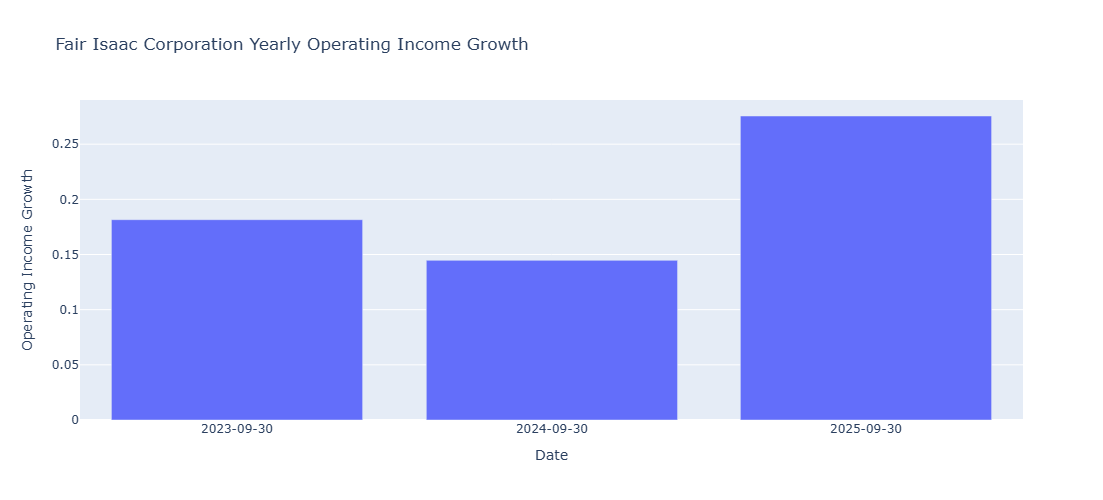

In [61]:
def get_oi_growth(ticker, income, ticks):
    #Graph Operating Income Growth for the previous 3 years
    loop = 1
    oig_list = []
    for oi in income.OperatingIncome.values:
        previous_oi = oi
        if loop >= 2:
            oig = (current_oi - previous_oi) / abs(previous_oi)
            oig_list.append(oig)
        loop += 1
        current_oi = oi
    # Create operating income growth dataframe
    oig = pd.DataFrame({'Operating Income Growth': oig_list}, index=income.index[:len(oig_list)])
    
    oig_bar = px.bar(oig, x=oig.index, y='Operating Income Growth', title=f"{ticker.info['shortName']} Yearly Operating Income Growth",
                     height=500)
    oig_bar.update_layout(xaxis_title='Date')
    oig_bar.update_xaxes(tickvals=oig.index, ticktext=ticks)
    oig_bar.show()
get_oi_growth(ticker=ticker, income=income_y, ticks=years)

## Operating Income Quarterly Growth

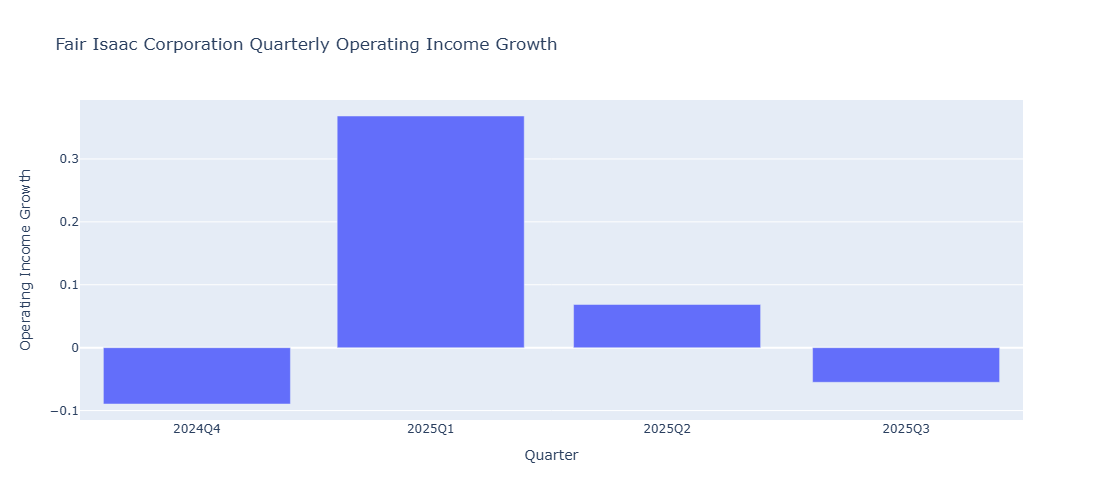

In [59]:
def get_oi_q_growth(ticker, income, ticks):
    #Graph Quarterly Operating Income Growth
    loop = 1
    oig_list = []
    for oi in income.OperatingIncome.values:
        previous_oi = oi
        if loop >= 2:
            oig = (current_oi - previous_oi) / abs(previous_oi)
            oig_list.append(oig)
        loop += 1
        current_oi = oi
    #Create quarterly operating income growth dataframe
    oig = pd.DataFrame({'Operating Income Growth': oig_list}, index=income.index[:len(oig_list)])
    #Drop null values
    oig = oig.dropna()
    
    oig_q_bar = px.bar(oig, x=oig.index, y='Operating Income Growth', title=f"{ticker.info['shortName']} Quarterly Operating Income Growth",
                     height=500)
    oig_q_bar.update_layout(xaxis_title='Quarter')
    oig_q_bar.update_xaxes(tickvals=oig.index, ticktext=ticks)
    oig_q_bar.show()
get_oi_q_growth(ticker=ticker, income=income_q, ticks=quarters)

## Yearly Operating Margin

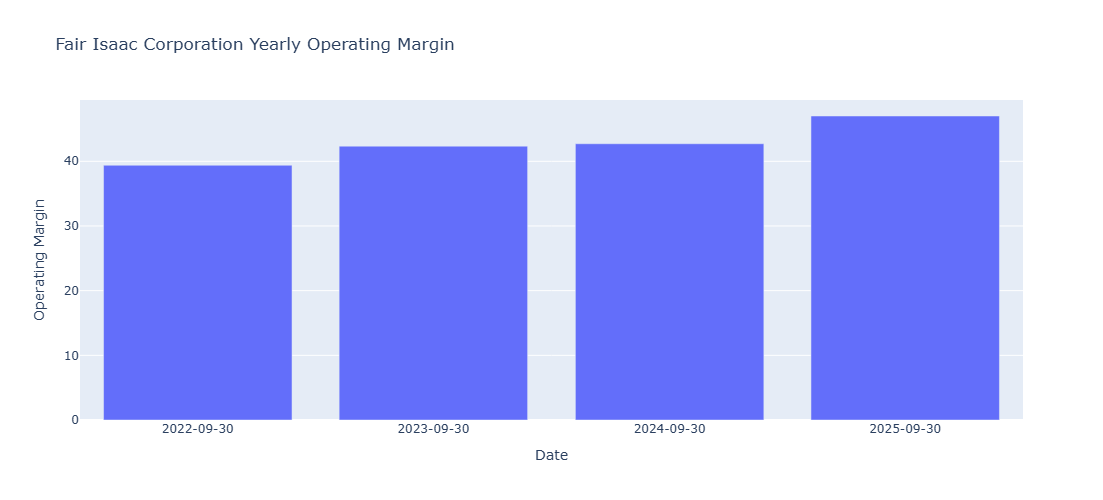

In [35]:
def get_operating_margin(ticker, income, ticks):
    # Graph yearly operating margin
    om = (income.OperatingIncome / income.TotalRevenue) * 100

    om_bar = px.bar(om, x=om.index, y=om.values, title=f"{ticker.info['shortName']} Yearly Operating Margin",
                   height=500)
    om_bar.update_layout(xaxis_title='Date', yaxis_title='Operating Margin')
    om_bar.update_xaxes(tickvals=income.index, ticktext=ticks)
    om_bar.show()
    return om
om = get_operating_margin(ticker=ticker, income=income_y, ticks=years)

## Quarterly Operating Margin

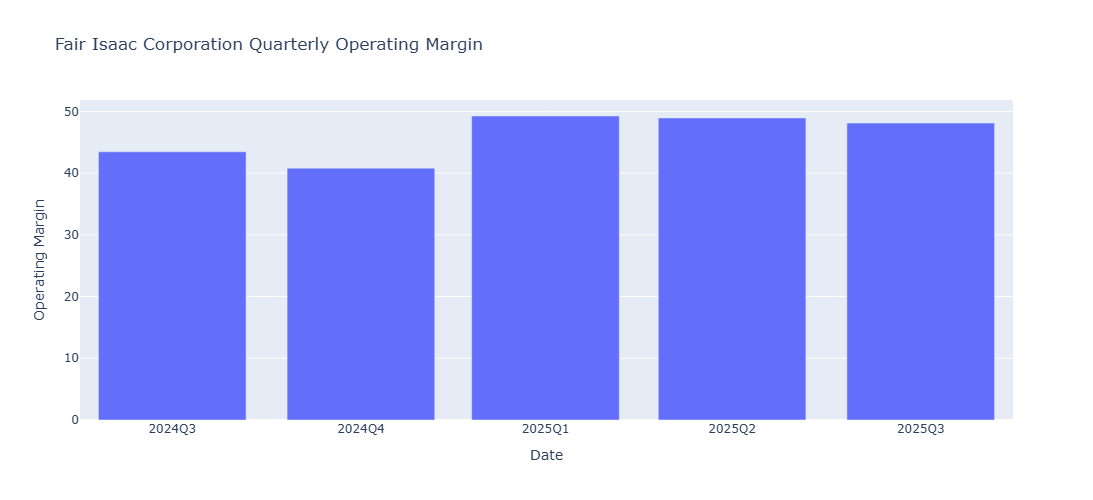

In [36]:
def get_operating_margin(ticker, income, ticks):
    # Graph yearly operating margin
    om_q = (income.OperatingIncome / income.TotalRevenue) * 100
    om_q = om_q.dropna()
    om_bar = px.bar(om_q, x=om_q.index, y=om_q.values, title=f"{ticker.info['shortName']} Quarterly Operating Margin",
                   height=500)
    om_bar.update_layout(xaxis_title='Date', yaxis_title='Operating Margin')
    om_bar.update_xaxes(tickvals=income.index, ticktext=ticks)
    om_bar.show()
    return om_q
om_q = get_operating_margin(ticker=ticker, income=income_q, ticks=quarters)

## Yearly Operating Margin Trend

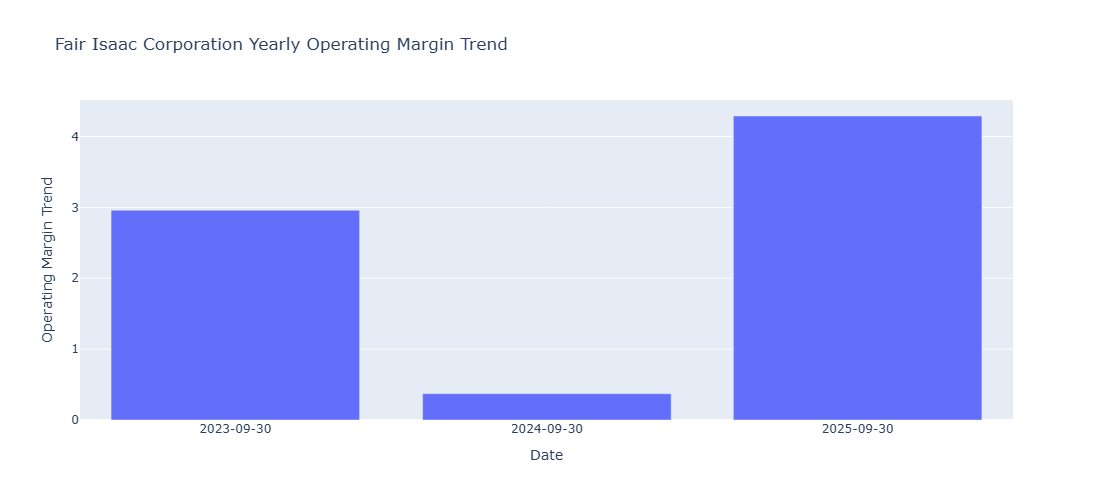

In [56]:
def get_om_trend(ticker, income, om_data, ticks):
    #Graph operating margin change
    loop = 1
    omt_list = []
    for om in om_data.values:
        previous_om = om
        if loop >= 2:
            omt = current_om - previous_om
            omt_list.append(omt)
        loop += 1
        current_om = om
    # Make new dataframe
    om_trend = pd.DataFrame({'Operating Margin Trend': omt_list}, index=ticks[:len(omt_list)])

    om_trend_bar = px.bar(om_trend, x=om_trend.index, y='Operating Margin Trend', title=f"{ticker.info['shortName']} Yearly Operating Margin Trend",
                          height=500)
    om_trend_bar.update_layout(xaxis_title='Date')
    om_trend_bar.update_xaxes(tickvals=om_trend.index, ticktext=ticks)
    om_trend_bar.show()

get_om_trend(ticker=ticker, income=income_y, om_data=om, ticks=years)

## Quarterly Operating Margin Trend

[-0.8390043387151565, -0.31486582560547305, 8.449427356689185, -2.6447711696025493]


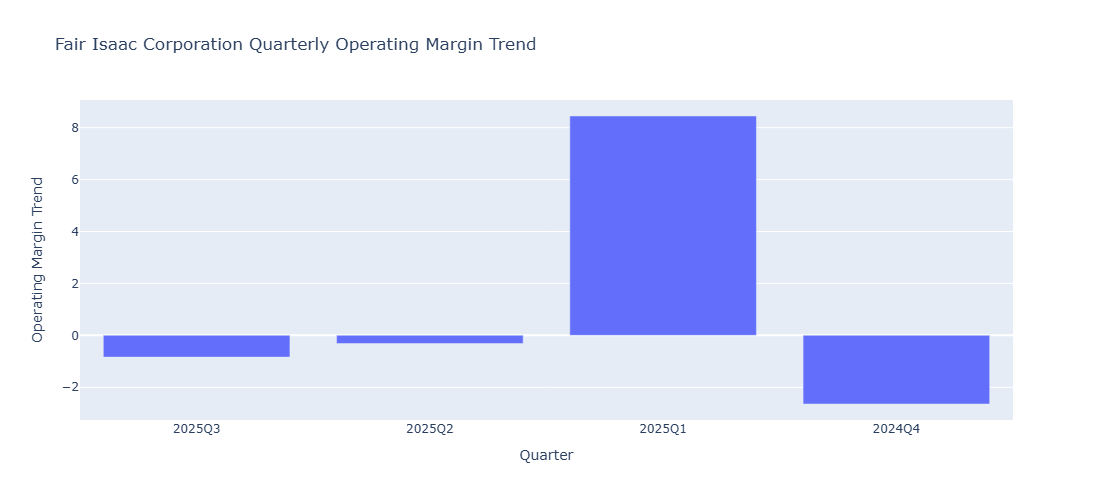

In [54]:
def get_om_q_trend(ticker, income, om_data, ticks):
    #Graph operating margin change
    loop = 1
    omt_list = []
    for om in om_data.values:
        previous_om = om
        if loop >= 2:
            omt = current_om - previous_om
            omt_list.append(omt)
        loop += 1
        current_om = om
    # Make new dataframe
    om_trend = pd.DataFrame({'Operating Margin Trend': omt_list}, index=ticks[:len(omt_list)])

    om_trend_bar = px.bar(om_trend, x=om_trend.index, y='Operating Margin Trend',
                          title=f"{ticker.info['shortName']} Quarterly Operating Margin Trend", height=500)
    om_trend_bar.update_layout(xaxis_title='Quarter')
    om_trend_bar.update_xaxes(tickvals=om_trend.index, ticktext=ticks)
    om_trend_bar.show()

get_om_q_trend(ticker=ticker, income=income_q, om_data=om_q, ticks=quarters)

## Yearly Gross Margin Stability

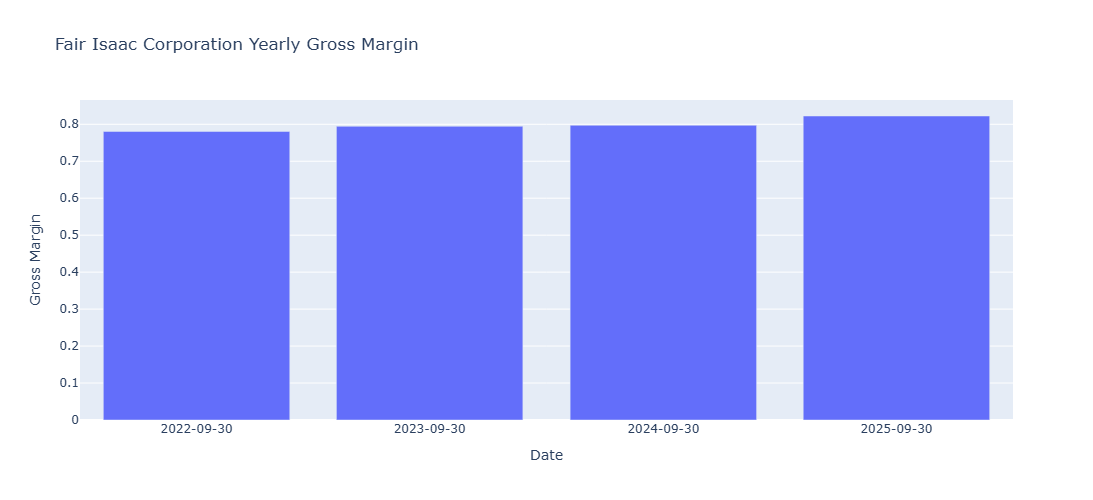

In [62]:
def get_gross_margin(ticker, income, ticks):
    #Graph yearly gross margin
    income['grossmargin'] = income.GrossProfit / income.TotalRevenue

    grossmargin_bar = px.bar(income, x=income.index, y='grossmargin', title=f"{ticker.info['shortName']} Yearly Gross Margin",
                             height=500)
    grossmargin_bar.update_layout(xaxis_title='Date', yaxis_title='Gross Margin')
    grossmargin_bar.update_xaxes(tickvals=income.index, ticktext=ticks)
    grossmargin_bar.show()
get_gross_margin(ticker=ticker, income=income_y, ticks=years)

## Quarterly Gross Margin

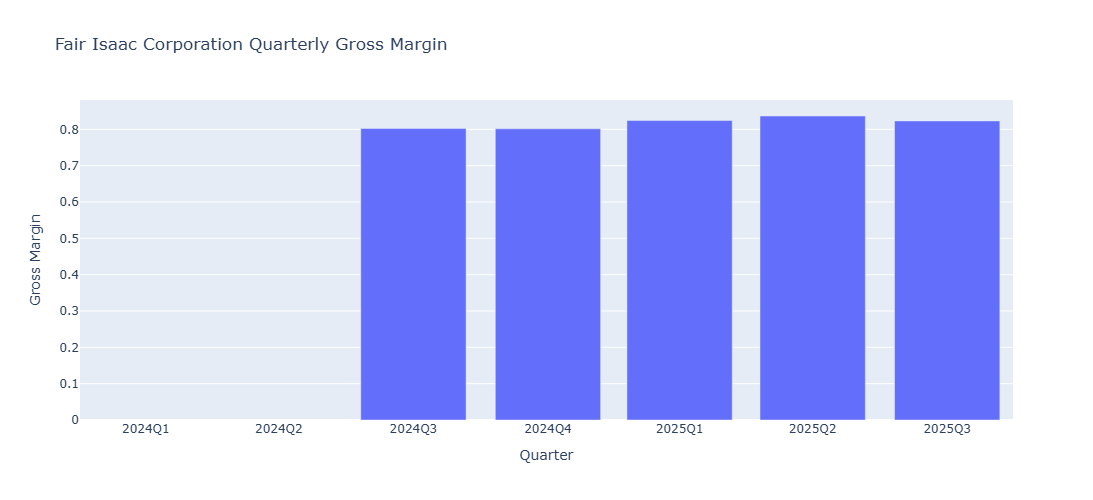

In [64]:
def get_gross_q_margin(ticker, income, ticks):
    #Graph yearly gross margin
    income['grossmargin'] = income.GrossProfit / income.TotalRevenue

    grossmargin_q_bar = px.bar(income, x=income.index, y='grossmargin', title=f"{ticker.info['shortName']} Quarterly Gross Margin",
                             height=500)
    grossmargin_q_bar.update_layout(xaxis_title='Quarter', yaxis_title='Gross Margin')
    grossmargin_q_bar.update_xaxes(tickvals=income.index, ticktext=ticks)
    grossmargin_q_bar.show()
get_gross_q_margin(ticker=ticker, income=income_q, ticks=quarters)

# Technical Analysis

In [65]:
def get_historical_prices(ticker):
    # Retrieve stock price history from past year and 3 years
    one_year = ticker.history(period='1y')
    three_year = ticker.history(period='3y')
    return one_year, three_year
history1, history3 = get_historical_prices(ticker=ticker)

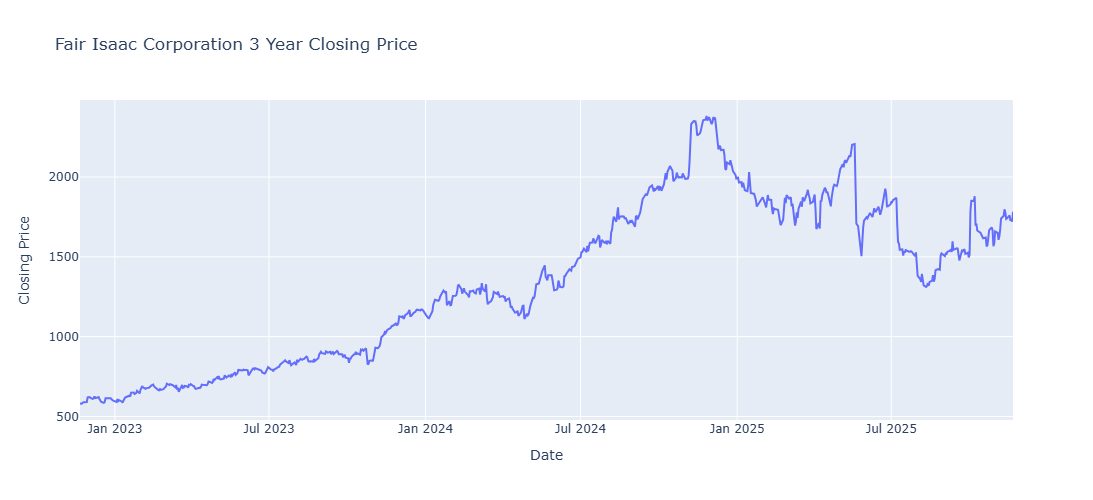

In [66]:
def plot_closing(ticker, history3):
    # Plot closing Price
    price_plot = px.line(history3, x=history3.index, y=history3.Close, title=f"{ticker.info['shortName']} 3 Year Closing Price", height=500)
    price_plot.update_layout(xaxis_title='Date', yaxis_title='Closing Price')
    price_plot.show()

plot_closing(ticker=ticker, history3=history3)

## RSI

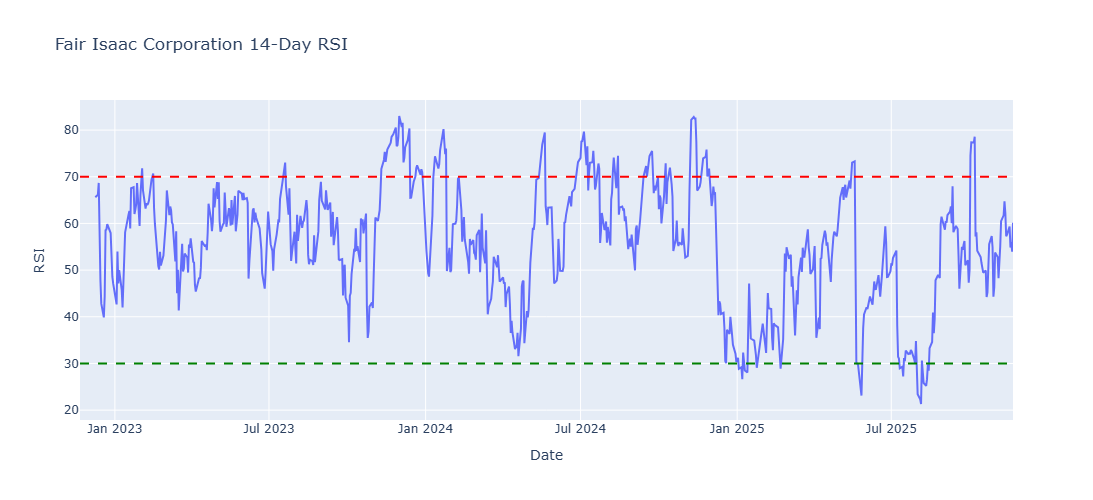

In [69]:
def get_rsi(ticker, history):
    # Plot rsi
    rsi_object = ta.momentum.RSIIndicator(close=history.Close, window=14)
    rsi = rsi_object.rsi()

    rsi_plot = px.line(history, x=history.index, y=rsi.values, title=f"{ticker.info['shortName']} 14-Day RSI", height=500)
    rsi_plot.update_layout(xaxis_title='Date', yaxis_title='RSI')
    rsi_plot.add_hline(y=70, line_dash='dash', line_color='red')
    rsi_plot.add_hline(y=30, line_dash='dash', line_color='green')
    rsi_plot.show()
    return rsi
rsi = get_rsi(ticker=ticker, history=history3)

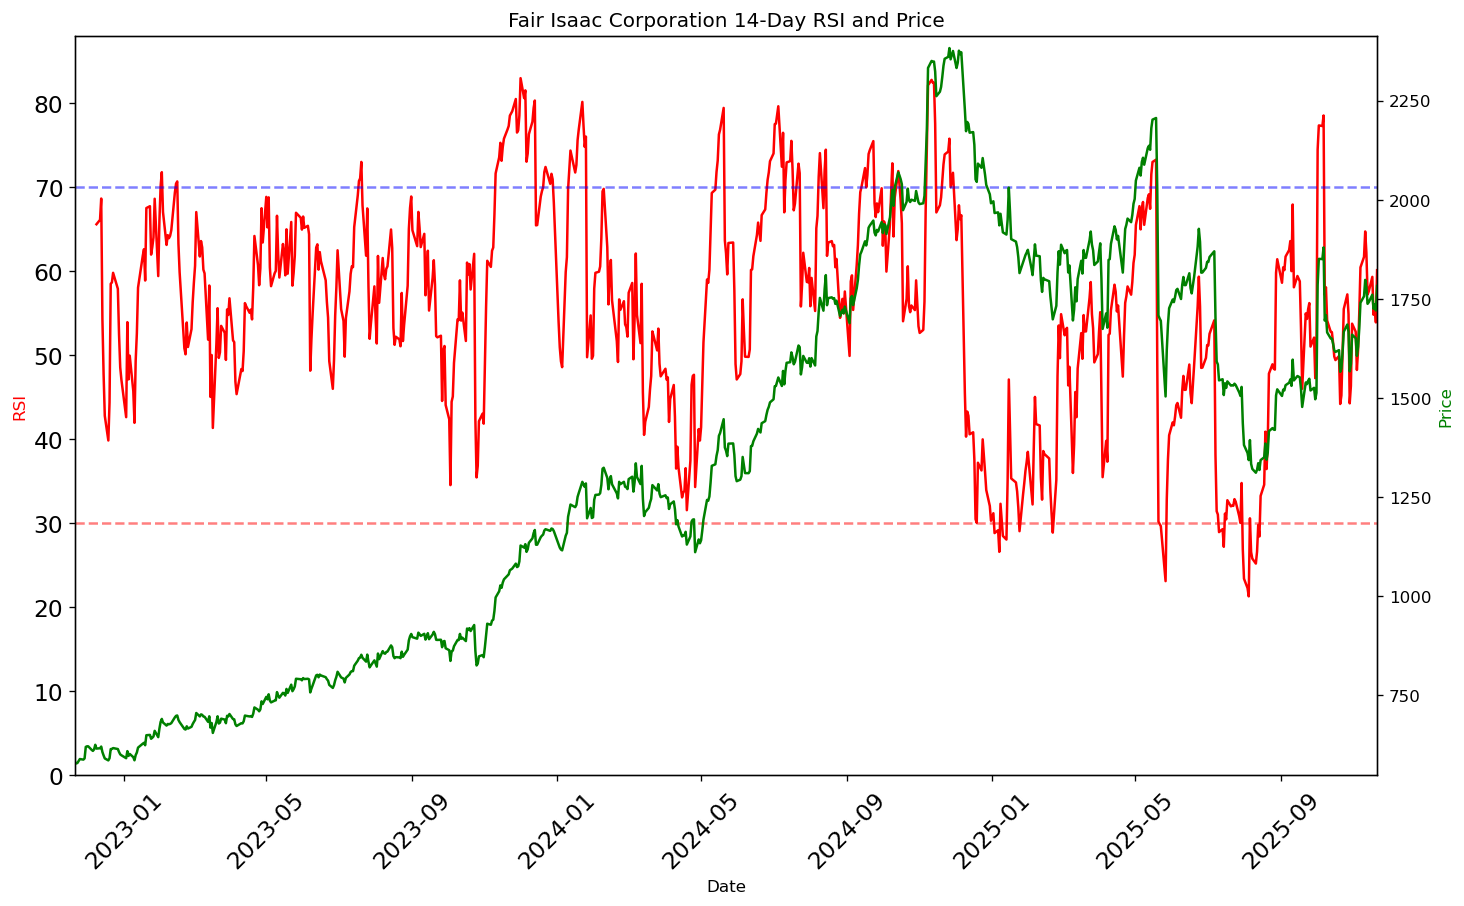

In [71]:
def plot_rsi_price(ticker, history, rsi):
    plt.figure(figsize=(14,8), dpi=120)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.title(f"{ticker.info['shortName']} 14-Day RSI and Price")
    
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    ax1.set_xlim([history.index.min(), history.index.max()])
    ax1.set_ylim([0, rsi.max() + 5])
    ax2.set_ylim([history.Close.min() - 30, history.Close.max() + 30])
    
    ax1.plot(history.index, rsi.values, color='red')
    ax2.plot(history.index, history.Close, color='green')
    ax1.axhline(y=70, linestyle='--', color='blue', alpha=0.5)
    ax1.axhline(y=30, linestyle='--', color='red', alpha=0.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RSI', color='red')
    ax2.set_ylabel('Price', color='green')

plot_rsi_price(ticker=ticker, history=history3, rsi=rsi)

## MACD

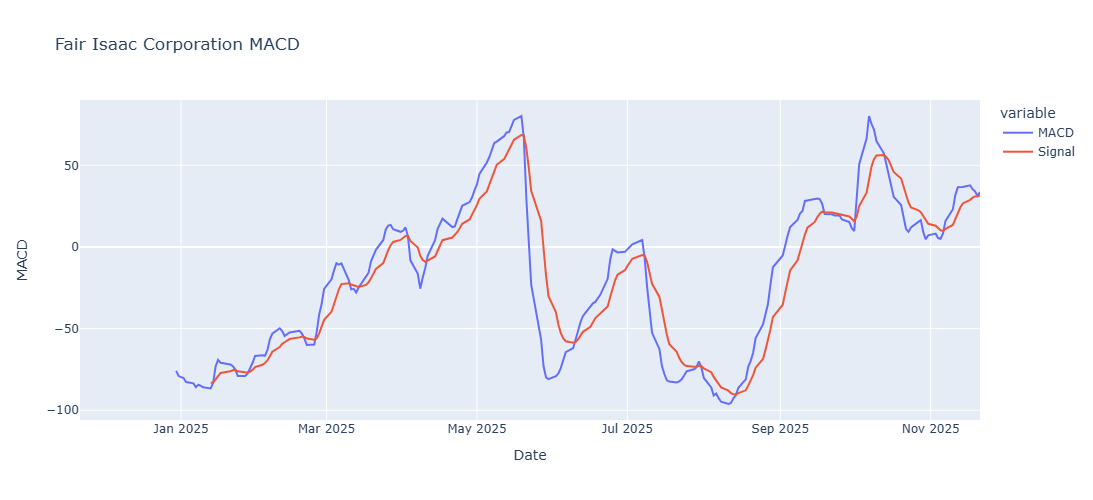

In [77]:
def get_macd(ticker, history):
    # Obtain macd line, signal line, and histogram
    macd_object = ta.trend.MACD(close=history.Close, window_slow=26, window_fast=12, window_sign=9)
    macd = macd_object.macd()
    signal_line = macd_object.macd_signal()
    histogram = macd_object.macd_diff()
    # Put into dataframe
    macd_df = pd.DataFrame({'MACD': macd, 'Signal': signal_line, 'Histogram': histogram}, index=history.index)
    #Plot
    macd_plot = px.line(macd_df, x=macd_df.index, y=['MACD', 'Signal'], title=f"{ticker.info['shortName']} MACD", height=500)
    macd_plot.update_layout(xaxis_title='Date', yaxis_title='MACD')
    macd_plot.show()
    return macd_df
macd_df = get_macd(ticker=ticker, history=history1)

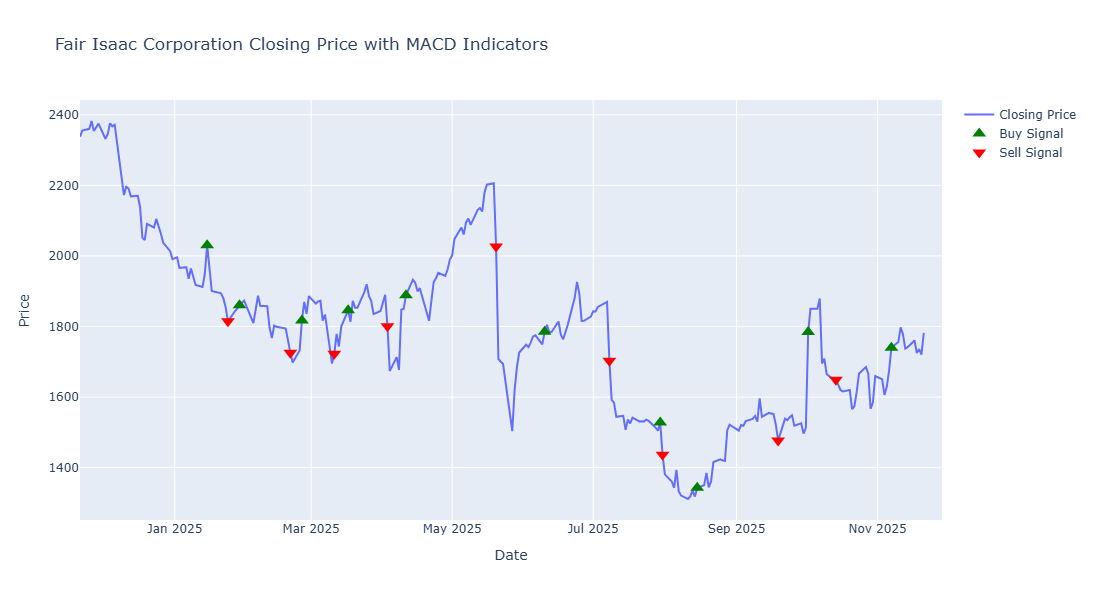

In [79]:
def plot_price_indicators(m, ticker, history):
    # Find indicators
    history['bullish_signal'] = (m.MACD > m.Signal) & (m.MACD.shift(1) < m.Signal.shift(1))
    history['bearish_signal'] = (m.MACD < m.Signal) & (m.MACD.shift(1) > m.Signal.shift(1))
    buy_dates = history[history['bullish_signal']].index
    sell_dates = history[history['bearish_signal']].index

    # Plot closing price with indicators
    price_signals = go.Figure()
    price_signals.add_trace(go.Scatter(x=history.index, y=history.Close, mode='lines', name='Closing Price'))
    price_signals.add_trace(go.Scatter(x=buy_dates, y=history.loc[buy_dates, 'Close'], mode='markers', marker_symbol='triangle-up',
                                  marker_color='green', name='Buy Signal', marker_size=12))
    price_signals.add_trace(go.Scatter(x=sell_dates, y=history.loc[sell_dates, 'Close'], mode='markers', marker_symbol='triangle-down',
                                   marker_color='red', name='Sell Signal', marker_size=12))
    price_signals.update_layout(yaxis_title='Price', xaxis_title='Date', height=600, 
                                title=f"{ticker.info['shortName']} Closing Price with MACD Indicators")
    price_signals.show()
    
plot_price_indicators(m=macd_df, ticker=ticker, history=history1)

## Stochastic Oscillator

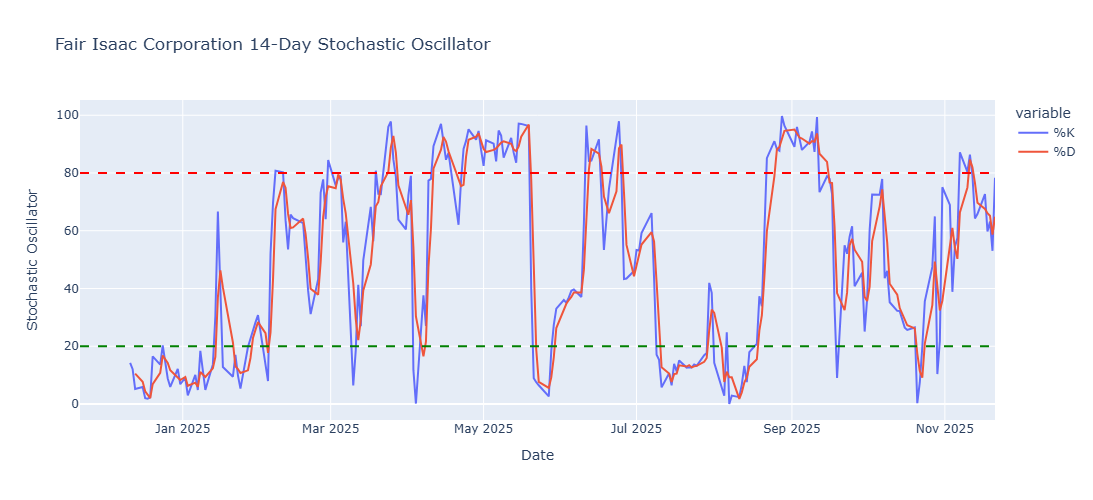

In [84]:
def get_stoch_osc(ticker, history):
    stoch = ta.momentum.StochasticOscillator(high=history['High'], close=history['Close'], low=history['Low'],
                                             window=14, smooth_window=3)
    history['%K'] = stoch.stoch()
    history['%D'] = stoch.stoch_signal()
    history_stoch = history.copy()
    stoch_plot = px.line(history, x=history.index, y=['%K', '%D'], title=f"{ticker.info['shortName']} 14-Day Stochastic Oscillator",
                            height=500)
    stoch_plot.update_layout(xaxis_title='Date', yaxis_title='Stochastic Oscillator')
    stoch_plot.add_hline(y=80, line_dash='dash', line_color='red')
    stoch_plot.add_hline(y=20, line_dash='dash', line_color='green')
    stoch_plot.show()
    return history_stoch
history_stoch = get_stoch_osc(ticker=ticker, history=history1)

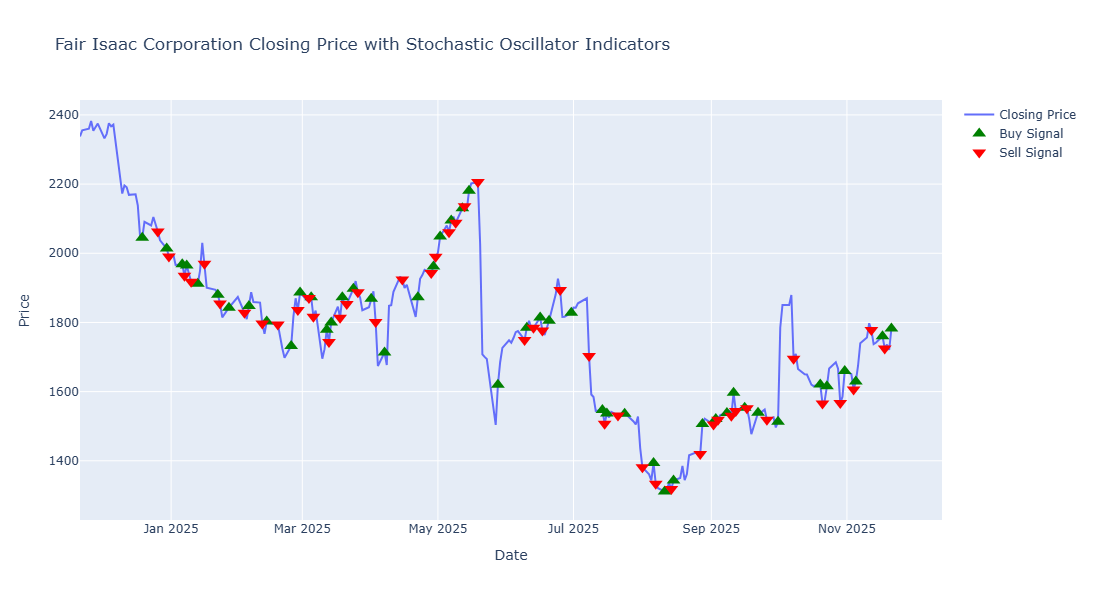

In [87]:
def plot_price_stoch(ticker, history):
    #Find buy and sell signals
    history['bullish_stoch'] = (history['%K'] > history['%D']) & (history['%K'].shift(1) < history['%D'].shift(1))
    history['bearish_stoch'] = (history['%K'] < history['%D']) & (history['%K'].shift(1) > history['%D'].shift(1))
    buy_dates_s = history[history['bullish_stoch']].index
    sell_dates_s = history[history['bearish_stoch']].index

    price_stoch = go.Figure()
    price_stoch.add_trace(go.Scatter(x=history.index, y=history.Close, mode='lines', name='Closing Price'))
    price_stoch.add_trace(go.Scatter(x=buy_dates_s, y=history.loc[buy_dates_s, 'Close'], mode='markers', marker_symbol='triangle-up',
                              marker_color='green', name='Buy Signal', marker_size=12))
    price_stoch.add_trace(go.Scatter(x=sell_dates_s, y=history.loc[sell_dates_s, 'Close'], mode='markers', marker_symbol='triangle-down',
                               marker_color='red', name='Sell Signal', marker_size=12))
    price_stoch.update_layout(yaxis_title='Price', xaxis_title='Date', height=600, 
                              title=f'{ticker.info['shortName']} Closing Price with Stochastic Oscillator Indicators')
    price_stoch.show()

plot_price_stoch(ticker=ticker, history=history_stoch)